# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Data Analysis
Summarize the characteristics of the dataset.

In [2]:
query_data = QueryData()
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
boxscores['ATTEMPTS'] = boxscores['TOTAL_ATTEMPTS']
boxscores['ATTEMPTS/POSSESSION'] = boxscores['ATTEMPTS']/boxscores['POSS']

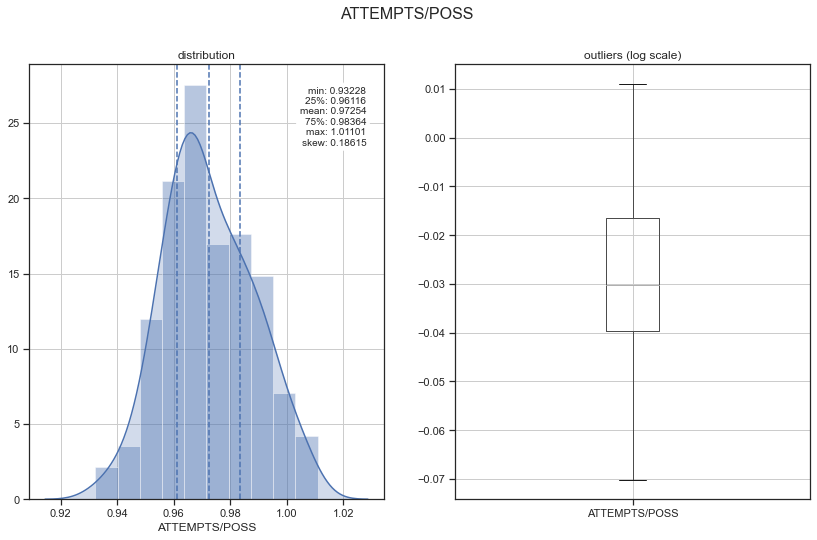

0.015794553289157298


In [12]:
grouped_team_boxscores = boxscores.groupby(['SEASON', 'TEAM']).apply(
    lambda x: pd.Series({
        'ATTEMPTS': x['TOTAL_ATTEMPTS'].sum(),
        'POSS': x['POSS'].sum()/5
    })
).reset_index()
grouped_team_boxscores['ATTEMPTS/POSS'] = grouped_team_boxscores['ATTEMPTS']/grouped_team_boxscores['POSS']
helpers.visualize_variable_distribution(grouped_team_boxscores, 'ATTEMPTS/POSS', figsize=(14, 8))
print(grouped_team_boxscores['ATTEMPTS/POSS'].std())

# Feature Engineering
Create new features from raw data using domain knowlege.

In [4]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ATTEMPTS/POSSESSION', new_col_name='AVG_ATTEMPTS/POSSESSION',
    weight_col_name='POSS'
)

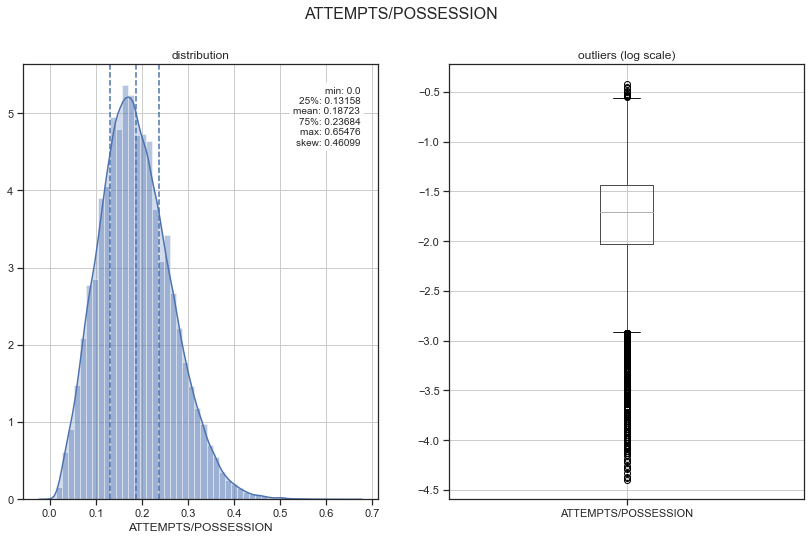

In [6]:
sig_boxscores = boxscores.loc[boxscores['POSS'] > 10]
helpers.visualize_variable_distribution(sig_boxscores, 'ATTEMPTS/POSSESSION', figsize=(14, 8))

In [8]:
pd.set_option('display.min_rows', 50)
display(boxscores[['DATE', 'TEAM', 'NAME', 'SECONDSPLAYED', 'ATTEMPTS', 'POSS', 'ATTEMPTS/POSSESSION', 'AVG_ATTEMPTS/POSSESSION']].dropna())

,DATE,TEAM,NAME,SECONDSPLAYED,ATTEMPTS,POSS,ATTEMPTS/POSSESSION,AVG_ATTEMPTS/POSSESSION
68,2014-10-29,LAL,Robert Sacre,720,5,22,0.227273,0.333333
73,2014-10-29,HOU,Trevor Ariza,2198,11,72,0.152778,0.172414
95,2014-10-29,HOU,Isaiah Canaan,490,3,14,0.214286,0.133333
116,2014-10-29,HOU,Jason Terry,1276,5,40,0.125000,0.116279
137,2014-10-29,HOU,Dwight Howard,1914,17,62,0.274194,0.317073
140,2014-10-29,HOU,Donatas Motiejunas,519,3,15,0.200000,0.090909
145,2014-10-29,HOU,Patrick Beverley,1839,6,57,0.105263,0.147541
146,2014-10-29,HOU,Tarik Black,966,5,29,0.172414,0.043478
176,2014-10-29,LAL,Jeremy Lin,1266,6,43,0.139535,0.118644
197,2014-10-29,LAL,Kobe Bryant,1673,26,54,0.481481,0.338983
